# Advent of Code 2023
## Day 20
*<https://adventofcode.com/2023/day/20>*

In [1]:
import heapq
import math
import re
import functools as ft
from collections import Counter, defaultdict, deque, namedtuple
from itertools import combinations, permutations, product
from string import ascii_letters, ascii_lowercase, ascii_uppercase

import IPython
import z3
from rich import inspect, pretty, print

from new_helper import *

pretty.install()

In [2]:
DAY = 20
input_str = get_aoc_input(DAY, 2023)
part_1 = part_2 = 0

In [3]:
inp = input_str.parse_lines()

In [4]:
HIGH = True
LOW = False
broadcast = namedtuple("broadcast", ["high", "src", "dst"])


class Module:
    name: str
    destinations: list[str]

    def __init__(self, name: str, destinations: list[str]):
        self.name = name
        self.destinations = destinations

    def __repr__(self):
        return f"{self.name} -> {', '.join(self.destinations)}"

    def high_pulse(self, src: str) -> list[broadcast]:
        return [broadcast(HIGH, self.name, n) for n in self.destinations]

    def low_pulse(self, src: str) -> list[broadcast]:
        return [broadcast(LOW, self.name, n) for n in self.destinations]

    def reset(self):
        pass


class FlipFlop(Module):
    on: bool

    def __init__(self, name: str, destinations: list[str]):
        super().__init__(name, destinations)
        self.on = False

    def __repr__(self):
        return "%" + super().__repr__()

    def high_pulse(self, src: str) -> list[broadcast]:
        return []

    def low_pulse(self, src: str) -> list[broadcast]:
        if self.on:
            self.on = False
            return [broadcast(LOW, self.name, n) for n in self.destinations]
        else:
            self.on = True
            return [broadcast(HIGH, self.name, n) for n in self.destinations]

    def reset(self):
        self.on = False


class Conj(Module):
    inputs: list[str]
    memory: dict[str, bool]

    def __init__(self, name: str, destinations: list[str]):
        super().__init__(name, destinations)
        self.inputs = []
        self.memory = {}

    def __repr__(self):
        return "&" + super().__repr__()

    def add_input(self, src: str):
        self.inputs.append(src)
        self.memory[src] = LOW

    def high_pulse(self, src: str) -> list[broadcast]:
        self.memory[src] = HIGH
        return [broadcast(not all(self.memory.values()), self.name, n) for n in self.destinations]

    def low_pulse(self, src: str) -> list[broadcast]:
        self.memory[src] = LOW
        return [broadcast(not all(self.memory.values()), self.name, n) for n in self.destinations]

    def reset(self):
        self.memory = {k: LOW for k in self.inputs}

In [5]:
modules: dict[str, Module] = {}
conjs: list[Conj] = []

for line in inp:
    src, dsts = line.split(" -> ")
    dsts = dsts.split(", ")

    if src[0] == "%":
        modules[src[1:]] = FlipFlop(src[1:], dsts)
    elif src[0] == "&":
        m = Conj(src[1:], dsts)
        modules[src[1:]] = m
        conjs.append(m)
    else:
        modules[src] = Module(src, dsts)


def parents(node: str) -> list[str]:
    return [src for src, m in modules.items() if node in m.destinations]


for conj in conjs:
    for p in parents(conj.name):
        conj.add_input(p)

In [6]:
total_high = 0
total_low = 0
for _ in range(1000):
    Q: deque[broadcast] = deque()
    Q.append(broadcast(LOW, "button", "broadcaster"))

    while Q:
        high, src, dest = Q.popleft()

        if dest not in modules:
            if high:
                total_high += 1
            else:
                total_low += 1
            continue

        if high:
            Q.extend(modules[dest].high_pulse(src))
            total_high += 1
        else:
            Q.extend(modules[dest].low_pulse(src))
            total_low += 1

part_1 = total_high * total_low

In [7]:
for m in modules.values():
    m.reset()

### Graphing Time

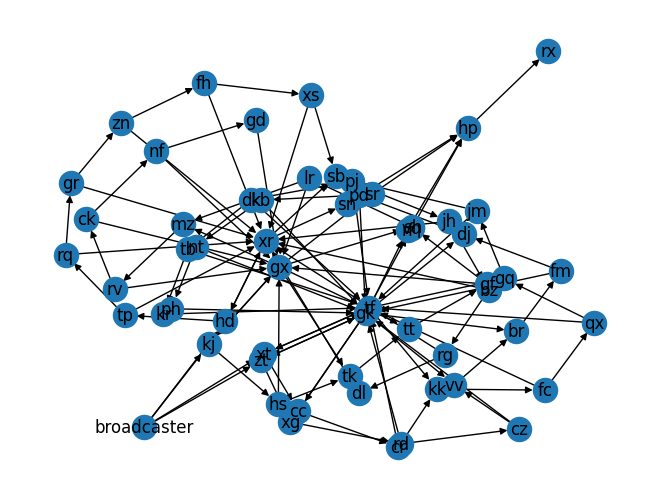

In [8]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(modules.keys())
for src, m in modules.items():
    for dst in m.destinations:
        G.add_edge(src, dst)

pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True)

### Exploiting the input

It seems like for all inputs, `rx` has only one parent, which is a conjugation module, in my case `&hp`. When all the parents of `&hp` broadcast a high signal simultaneously, `&hp` will send a low signal to `rx`. This does make a few other assumptions, but it seems to work.

In [9]:
cycle: dict[str, int | None] = {p: None for p in flatten([parents(p) for p in parents("rx")])}
checked = set()

n = 0
part_2 = 1
done = False
while not done:
    n += 1

    Q: deque[broadcast] = deque()
    Q.append(broadcast(LOW, "button", "broadcaster"))

    while Q:
        is_high, src, dest = Q.popleft()

        if not is_high:
            if dest in cycle:
                if cycle[dest] is not None and dest not in checked:
                    part_2 = math.lcm(part_2, n - cycle[dest])
                    checked.add(dest)

                    if len(checked) == len(cycle):
                        done = True
                        break

                else:
                    cycle[dest] = n

        if dest not in modules:
            continue

        if is_high:
            Q.extend(modules[dest].high_pulse(src))
        else:
            Q.extend(modules[dest].low_pulse(src))

In [10]:
print_part_1(part_1)
print_part_2(part_2)

Part 1: 812609846

Part 2: 245114020323037